In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import pandas as pd

from datetime import datetime

import importlib

from tqdm import tqdm

In [4]:
satds = xr.open_mfdataset('/petastore/phil/Prasoon_satellite_project/sat_files_for_phil/20130317/F16.nc').load() ## Changed paths so they're accessible to me (aaron). 

In [5]:
#!!!!! SOMEONE (Prasoon) needs to make this file. Use the default regridding settings to interpolate the SAMI outputs to a geographic grid.

samids = xr.open_mfdataset('/petastore/phil/Prasoon_satellite_project/glob__SAMI_REGRID.nc').load() # PATH TO SAMI REGRID (NORMAL RUN)

In [6]:
samids

<xarray.Dataset>
Dimensions:  (time: 307, alt: 80, lat: 90, lon: 90)
Coordinates:
  * time     (time) datetime64[ns] 2013-03-17T00:09:57.600000 ... 2013-03-18T...
  * alt      (alt) int64 200 225 250 275 300 325 ... 2075 2100 2125 2150 2175
  * lat      (lat) int64 -90 -88 -86 -84 -82 -80 -78 ... 76 78 80 82 84 86 88
  * lon      (lon) int64 0 4 8 12 16 20 24 28 ... 332 336 340 344 348 352 356
Data variables:
    edens    (time, lon, lat, alt) float64 1.23e+05 2.118e+05 ... 0.0 0.0

In [8]:
satlocdf = pd.read_csv('/petastore/phil/Prasoon_satellite_project/satfiles/20130317/DMSP_all-with_datetime.csv')

f16 = satlocdf.where(satlocdf.sat == 16.0).dropna().reset_index(drop=True)

In [9]:
'''
SELF-NOTE
Note that the e_dens is having a dimension of 597*4320
this is due to the fact that at any time, sami is able
to calculate density at all the points. However, the
satellite data can only calculate the density of the 
coordinate at which it is present. So, get the glat and
glon at a particular point using the sat_time and then
use sami_time that is nearer to this sat_time.
'''

satds


<xarray.Dataset>
Dimensions:    (sami_time: 597, sat_time: 4320)
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:39:54
    glat       (sat_time) float64 2.8 6.3 9.8 13.3 16.8 ... 53.3 49.9 46.5 43.0
    glon       (sat_time) float64 261.2 260.5 259.7 258.9 ... 92.7 91.2 89.9
  * sat_time   (sat_time) datetime64[ns] 2013-03-16 ... 2013-03-18T23:59:00
Data variables:
    e_dens     (sami_time, sat_time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [10]:
f16

,glat,glon,time,sat,dayofyear,dtime
0,2.8,261.2,0.0,16.0,75.0,2013-03-16 00:00:00
1,6.3,260.5,60.0,16.0,75.0,2013-03-16 00:01:00
2,9.8,259.7,120.0,16.0,75.0,2013-03-16 00:02:00
3,13.3,258.9,180.0,16.0,75.0,2013-03-16 00:03:00
4,16.8,258.0,240.0,16.0,75.0,2013-03-16 00:04:00
...,...,...,...,...,...,...
4315,56.7,96.1,86100.0,16.0,77.0,2013-03-18 23:55:00
4316,53.3,94.3,86160.0,16.0,77.0,2013-03-18 23:56:00
4317,49.9,92.7,86220.0,16.0,77.0,2013-03-18 23:57:00
4318,46.5,91.2,86280.0,16.0,77.0,2013-03-18 23:58:00


In [14]:
"""

from aaron - 


All of the glat values that you pull from f16 are already in the satds file. 

No reason to load that data twice.
    - Might help you keep all the data organized & what not to have as few things pointing
        to the same stuff as possible. Definitely makes it more readable.
        
(I won't change anything - just pointing it out.)
        
"""

# Count how many of the two glat/glon's are not equal, elementwise.
np.sum(f16['glat'] != satds.glat.values), np.sum(f16['glon'] != satds.glon.values)

(0, 0)

In [17]:
# All the Satellite passes possible

from scipy.signal import find_peaks

max_ind, _ = find_peaks(satds['glat'])
min_ind, _ = find_peaks(-satds['glat'])
print('Indices of maximum latitude -', max_ind, '\n\n\n') # You can use "\n" as a newline character
print('Indices of minimum latitude -', min_ind)

pass_num = 10
start_ind = max_ind[pass_num]
end_ind = min_ind[pass_num]

Indices of maximum latitude - [  25  127  229  330  432  534  636  738  840  942 1044 1146 1248 1350
 1452 1554 1656 1758 1859 1961 2063 2165 2267 2369 2471 2573 2675 2777
 2879 2981 3083 3185 3287 3388 3490 3592 3694 3796 3898 4000 4102 4204
 4306] 



Indices of minimum latitude - [  76  178  279  381  483  585  687  789  891  993 1095 1197 1299 1401
 1503 1605 1707 1808 1910 2012 2114 2216 2318 2420 2522 2624 2726 2828
 2930 3032 3134 3235 3337 3439 3541 3643 3745 3847 3949 4051 4153 4255]


In [ ]:
"""
- So that cell above will give us satellite passes. But thinking ahead, it may be difficult to 
generalize and run for many satellite passes at a time, or to look at both descending and ascending satellite passes...


Instead, it may be better to do find_peaks on the absolute values of lat's. Then to get the
start, peak_ind[ipassnum], and the end is peak_ind[ipassnum+1]


Let me try it and plot both out indices out...

""" 

In [45]:
peak_inds = find_peaks(np.abs(satds['glat'].values))[0]
# Just using the [0] might be easier to understand than the "peaks, _ = findpeaks()""

In [46]:
peak_inds

array([  25,   76,  127,  178,  229,  279,  330,  381,  432,  483,  534,
        585,  636,  687,  738,  789,  840,  891,  942,  993, 1044, 1095,
       1146, 1197, 1248, 1299, 1350, 1401, 1452, 1503, 1554, 1605, 1656,
       1707, 1758, 1808, 1859, 1910, 1961, 2012, 2063, 2114, 2165, 2216,
       2267, 2318, 2369, 2420, 2471, 2522, 2573, 2624, 2675, 2726, 2777,
       2828, 2879, 2930, 2981, 3032, 3083, 3134, 3185, 3235, 3287, 3337,
       3388, 3439, 3490, 3541, 3592, 3643, 3694, 3745, 3796, 3847, 3898,
       3949, 4000, 4051, 4102, 4153, 4204, 4255, 4306])

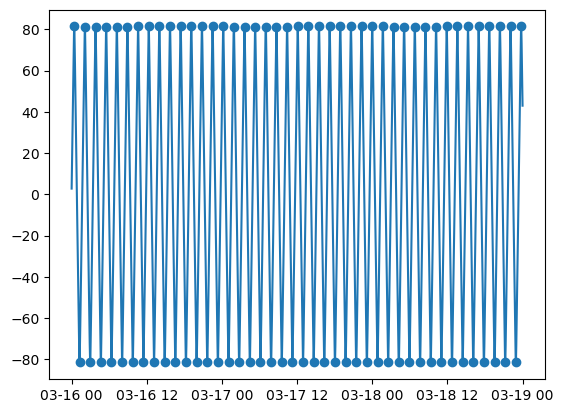

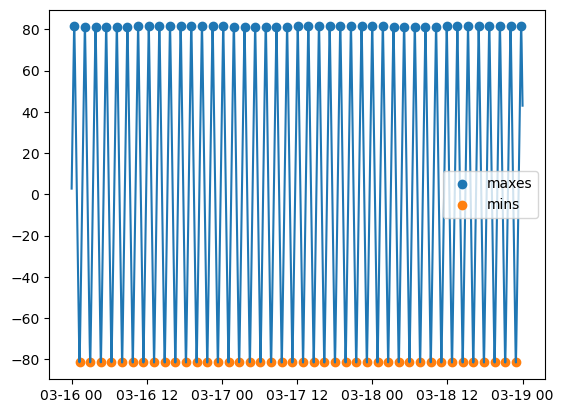

In [51]:
plt.plot(satds.sat_time, satds.glat)
plt.scatter(satds.sat_time[peak_inds], satds.glat[peak_inds])
plt.show()

plt.plot(satds.sat_time, satds.glat)
plt.scatter(satds.sat_time[max_ind], satds.glat[max_ind], label='maxes')
plt.scatter(satds.sat_time[min_ind], satds.glat[min_ind], label='mins')
plt.legend()
plt.show()

In [ ]:
# SO they look the same! But one will be easier to use later (mine)

In [29]:
sattimes = pd.to_datetime(f16.dtime).to_numpy()

sattimes[0], sattimes[len(sattimes)-1], sattimes[1] - sattimes[0], satds.sat_time[3].values,  type(satds.isel(sat_time=0).sat_time.values)

(numpy.datetime64('2013-03-16T00:00:00.000000000'),
 numpy.datetime64('2013-03-18T23:59:00.000000000'),
 numpy.timedelta64(60000000000,'ns'),
 numpy.datetime64('2013-03-16T00:03:00.000000000'),
 numpy.datetime64)

In [34]:
## Comment here, not necessary for project but just for your info...

# take a look at this:

a = [1,2,3,4,5,6]
print(a[0], a[len(a)-1])

print(a[0], a[-1]) # You can index with negative numbers...
print(a[:2], a[-2:]) # and use a : to slice multiple values, even with negative numbers


print('\n\n\n\n\n')

## Also, sometimes you will want to print names of variables instead 
#    of just the variables like you did in the cell above. 2 ways to do this:

print(' first time: ', sattimes[0], 
      '\n last time: ',sattimes[-1],
      '\n time step: ', sattimes[1] - sattimes[0],
      '(or): ',pd.Timedelta(sattimes[1] - sattimes[0]),
      '\n third time: ', satds.sat_time[3].values,
      '\n and type: ', type(satds.isel(sat_time=0).sat_time.values))


print('\n\n\n\n\n')


# -I like to do the below method more. It's more readable and easier to write...
#  -We use %s to tell python that we'll give it a string later, 
#    then put the strings in the %() stuff in line 38..

#     -(%s is string, %i is integer, %f is float, and there are more you can find later)
#     -You can look up more info by googling "python print function's with percent symbol"...


print('The first time is: %s, \nThe second time is: %s, \n'
      'The timestep (in numpy format): %s, or %s in pd.Timedelta format\n'
      'and the type is: %s'
      %(sattimes[0], sattimes[-1], sattimes[1]-sattimes[0],
        pd.Timedelta(sattimes[1] - sattimes[0]),
       type(satds.isel(sat_time=0).sat_time.values)))

1 6
1 6
[1, 2] [5, 6]






 first time:  2013-03-16T00:00:00.000000000 
 last time:  2013-03-18T23:59:00.000000000 
 time step:  60000000000 nanoseconds (or):  0 days 00:01:00 
 third time:  2013-03-16T00:03:00.000000000 
 and type:  <class 'numpy.datetime64'>






The first time is: 2013-03-16T00:00:00.000000000, 
The second time is: 2013-03-18T23:59:00.000000000, 
The timestep (in numpy format): 60000000000 nanoseconds, or 0 days 00:01:00 in pd.Timedelta format
and the type is: <class 'numpy.datetime64'>


In [35]:
from scipy.interpolate import CubicSpline
# I have comments here. Going to leave it all in place and just write about it below...

interpolated_edens = []

lat = (f16['glat'])[start_ind:end_ind+1]
lon = (f16['glon'])[start_ind:end_ind+1]
time = sattimes[start_ind:end_ind+1]

sami_start = 0
sami_end = 0

sami_time = satds['sami_time']

'''
for i in range(start_ind, end_ind+1):
    interpolated_edens.append(
        satds.isel(glat=i,glon=i, alt=840).edens.interp(sat_time=sattimes[i]).values)
'''

for i in range(len(sami_time)-1):
    if sami_time[i] <= time[0] and sami_time[i+1] > time[0]:
        sami_start = i
    if sami_time[i] <= time[-1] and sami_time[i+1] > time[-1]:
        sami_end = i
        break

#sami_passing = sami_time[sami_start:sami_end+1]
sami_passing = pd.to_datetime(sami_time[sami_start:sami_end+1]).to_numpy()

for i in range(start_ind, end_ind+1):
    sami_data = []
    sami_sec = []

    #interpolated_edens.append(
    #    satds.sel(sat_time=sattimes[i], sami_time=sattimes[i], method='nearest').e_dens.interp(sat_time=sattimes[i]).values)

    for j in range(len(sami_passing)):
        
        seconds = (sami_passing[j] - np.datetime64('2013-03-16T00:00:00')) / np.timedelta64(1, 's')
        sami_sec.append(seconds)
        
        ## COMMENT 
        # - you had a "Z" at the end of the np.datetime64(). This means "Zulu time"
        #  or GMT or something. That's a time zone. Getting rid of it gets rid of that error :)
        
        ## ALSO:
        # if you're looping thru the vales of one array, you don't need to do range(len())
        #   we can just say "for time in arr:""
        
        sami_data.append(satds.sel(sami_time=sami_passing[j]).e_dens.interp(sat_time=sattimes[i]).values)
    
    cs = CubicSpline(sami_sec, sami_data)
    seconds2 = (sattimes[i] - np.datetime64('2013-03-16T00:00:00')) / np.timedelta64(1, 's')
    interpolated_edens.append(float(cs(seconds2)))


print('interpolated_edens', interpolated_edens)


interpolated_edens [41203.893287179344, 46982.768695992745, 50637.34403905363, 45532.68169658318, 38215.63948924685, 32847.287075642496, 30426.012531034317, 24992.921033799044, 18868.430048010992, 18309.673510792953, 19801.373415652906, 21710.487217398935, 22709.553590157157, 21490.248824501687, 19674.003005741924, 17527.50860664732, 15972.696016436168, 14572.783979807085, 13846.810573515093, 13371.957282804306, 12818.73305279519, 12486.19101333358, 12478.965961230402, 12705.91890278389, 12981.821560081275, 12809.63324806098, 12444.645537177887, 11078.983506998535, 9551.19763010096, 8800.894960577067, 8910.419070023461, 9119.956105583258, 9545.51534669245, 9864.210873803162, 9912.736466015791, 9527.212660073494, 8509.891729483556, 6962.648602997659, 5607.2702690697915, 4257.510114065811, 3391.6668512106075, 3422.4171474194354, 4464.627405093431, 5325.2131171166375, 7589.19021827284, 10489.466168340072, 12476.89295863312, 17742.072294472757, 20870.212935209824, 17154.884710760125, 15155

In [112]:
"""

This works great! I think....


Now we want to do it for all the satellite times, not just the pass we want to look at right now.

Then we will select passes later.

So I'm just going to generalize it and run it for all times and put it into a pandas DataFrame (you can switch over to xarray if you want)
    - This is the only problem I have with what you did. The rest is perfect. We need to know when (and thus, where) the measurements correspond to.
    - Then we won't have to mess with the ticks like you did in the plot below!
    
    
Side note... I don't know why a lot of those lines of code are in there. Like why are lines 10 & 11 necessary?
- Looking more closely, i think you definitely made this more complicated than it has to be, haha. 
    - No reason to not use all of the sami_times. We don't have a lot of interpolating to do so it'll be fast either way. 

""";

In [88]:
## NOW Aaron's turn to do that:

In [108]:
interpd_df = pd.DataFrame()
interpd_df['time'] = satds.sat_time.values
interpd_df['glat'] = satds.glat.values
interpd_df['glon'] = satds.glon.values

In [109]:
interpd_df = interpd_df.iloc[np.where(interpd_df.time < satds.sami_time.max().values)]
# Make sure we don't go past the last sami_time
interpd_df

,time,glat,glon
0,2013-03-16 00:00:00,2.8,261.2
1,2013-03-16 00:01:00,6.3,260.5
2,2013-03-16 00:02:00,9.8,259.7
3,2013-03-16 00:03:00,13.3,258.9
4,2013-03-16 00:04:00,16.8,258.0
...,...,...,...
2975,2013-03-18 01:35:00,68.2,215.7
2976,2013-03-18 01:36:00,71.4,211.1
2977,2013-03-18 01:37:00,74.4,204.7
2978,2013-03-18 01:38:00,77.2,195.6


In [110]:

interpolated_edens = []

for itime in interpd_df.time:
    itime = itime.to_numpy()
    if itime < satds.sami_time.max():
        fitter = CubicSpline(satds.sami_time,
                            satds.e_dens.sel(sat_time=itime))

        interpolated_edens.append(fitter(itime))



In [111]:
interpd_df['edens'] = interpolated_edens
interpd_df

,time,glat,glon,edens
0,2013-03-16 00:00:00,2.8,261.2,0.0
1,2013-03-16 00:01:00,6.3,260.5,7869.795162797138
2,2013-03-16 00:02:00,9.8,259.7,14006.378862105887
3,2013-03-16 00:03:00,13.3,258.9,18074.737351132033
4,2013-03-16 00:04:00,16.8,258.0,21665.22605162398
...,...,...,...,...
2975,2013-03-18 01:35:00,68.2,215.7,59704.5884799736
2976,2013-03-18 01:36:00,71.4,211.1,58839.75451740103
2977,2013-03-18 01:37:00,74.4,204.7,48831.87467664626
2978,2013-03-18 01:38:00,77.2,195.6,33813.746077858304


['17:24:00', '17:34:00', '17:44:00', '17:54:00', '18:04:00', '18:14:00']


Text(0.5, 0, 'sat_time')

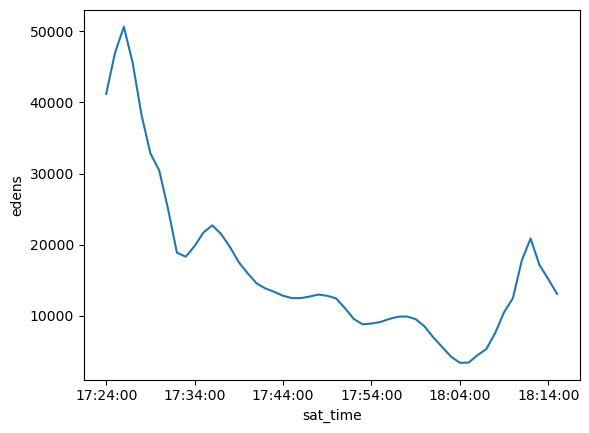

In [170]:
x_ticks = []
labels = []
for i in range(start_ind, end_ind, 10):
    x_ticks.append(i - start_ind)
    labels.append((sattimes[i]).astype('datetime64[s]').astype(str)[-8:])
print(labels)

plt.figure()
plt.plot(interpolated_edens)
plt.xticks(x_ticks, labels=labels)
plt.ylabel('edens')
plt.xlabel('sat_time')

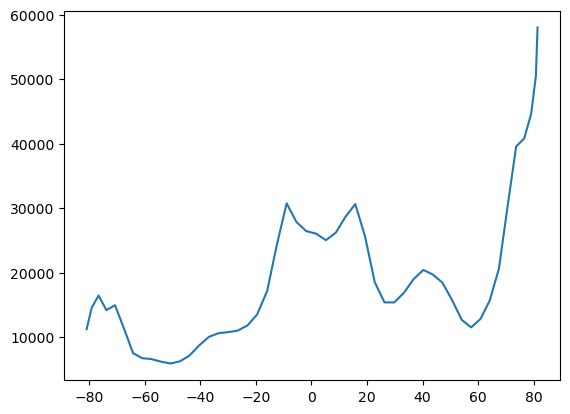

In [192]:
# And here's how easy it is to plot out...

ipassnum = 48

plt.plot(interpd_df.glat[peak_inds[ipassnum]:peak_inds[ipassnum+1]], 
         interpd_df.edens[peak_inds[ipassnum]:peak_inds[ipassnum+1]])
plt.show();


In [ ]:
## Now look at comparisons of a single pass to TEC

# TEC = total electron content (vertically integrated electron density)

# Here is some example code, you'll have to find more passes and do something similar.

In [193]:
single_pass_df = interpd_df[peak_inds[ipassnum]:peak_inds[ipassnum+1]].reset_index(drop=True)
single_pass_df.head()

,time,glat,glon,edens
0,2013-03-17 17:11:00,81.4,275.3,58040.21602695957
1,2013-03-17 17:12:00,80.8,252.4,50529.05566887543
2,2013-03-17 17:13:00,79.1,234.6,44637.934974689815
3,2013-03-17 17:14:00,76.6,222.4,40825.32649719969
4,2013-03-17 17:15:00,73.7,214.0,39574.82939066531


<Axes: >

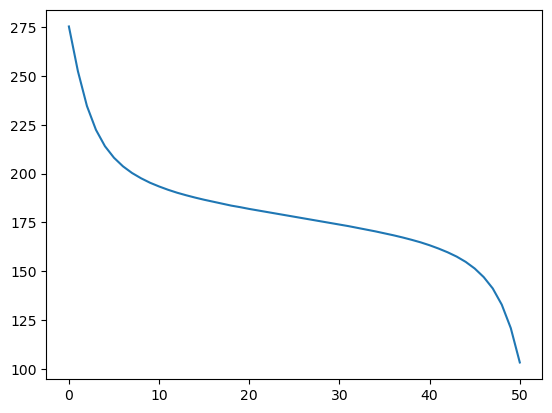

In [194]:
single_pass_df.glon.plot() # glon is approx constant...

In [195]:
glon_here = single_pass_df.glon.mean()

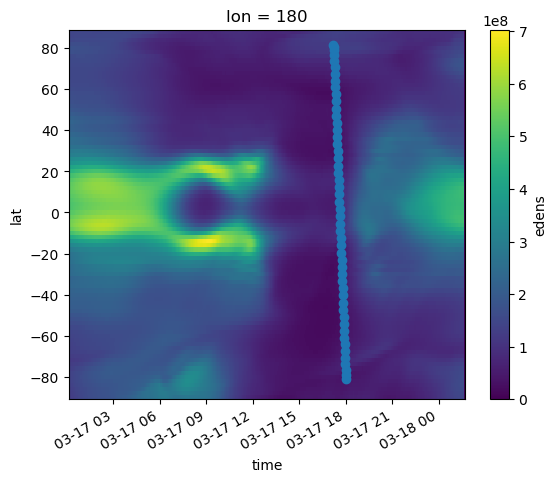

In [196]:
samids.edens.sel(lon=glon_here, method='nearest').integrate('alt').plot(x='time')
# plt.show()

plt.scatter(single_pass_df.time, single_pass_df.glat)


In [197]:


from scipy.signal import butter, sosfiltfilt, sosfilt_zi, sosfilt, lfilter, filtfilt


def filt_filt(da,
              freq=5,
              lims=[40, 85],
              order=1,
              percent=True):

    # Define sampling frequency and limits in minutes
    sampling_freq = freq
    lower_limit = min(lims)
    upper_limit = max(lims)

    # Convert limits to corresponding indices
    lower_index = int(lower_limit / sampling_freq)
    upper_index = int(upper_limit / sampling_freq)

    # Design the bandpass filter
    nyquist_freq = 0.5 * sampling_freq
    lower_cutoff = lower_index / nyquist_freq
    upper_cutoff = upper_index / nyquist_freq
    b, a = butter(order, [1/upper_cutoff, 1/lower_cutoff],
                  btype='band', analog=False)

    # Apply the filter to the data
    filtd = filtfilt(b, a, da, axis=0)
    # filtd = xr.apply_ufunc(filtfilt, b, a, da, dask='allowed')

    if percent:
        return (100*(filtd)/da)

    else:
        da.values = filtd
        return da

In [203]:
# full view:

/home/axb170054/.conda/envs/xesmf/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


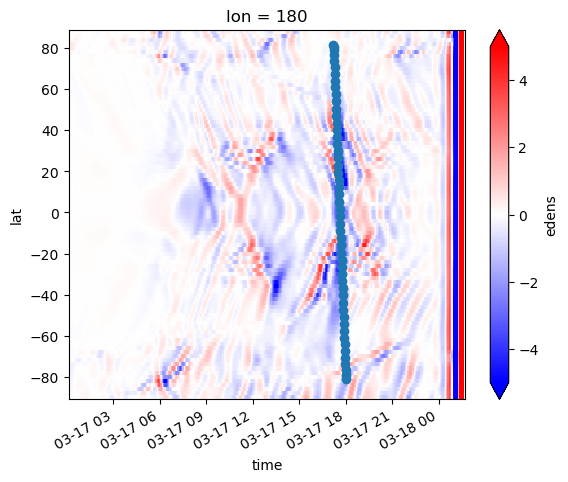

In [204]:
filt_filt(samids.edens.sel(lon=glon_here, method='nearest').integrate('alt')).plot(x='time', vmin=-5, vmax=5, cmap='bwr')

plt.scatter(single_pass_df.time, single_pass_df.glat)

/home/axb170054/.conda/envs/xesmf/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


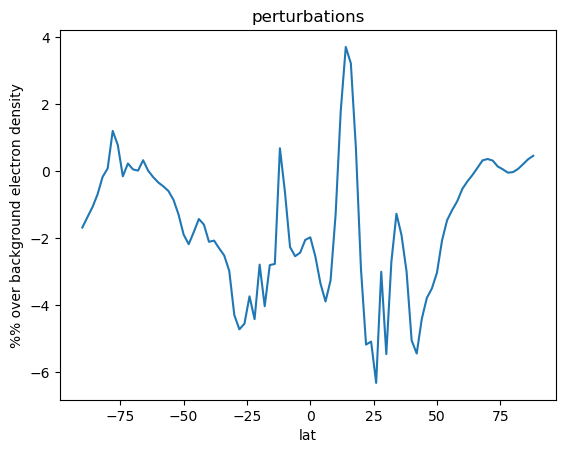

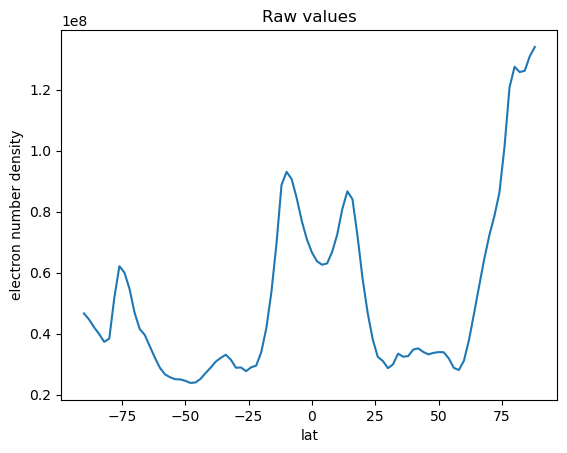

In [210]:
# And now look at a line plot:

filt_filt(samids.edens.sel(lon=glon_here, method='nearest').integrate('alt')).sel(
    time=single_pass_df.time.mean(), method='nearest').plot()
plt.title('perturbations')
plt.ylabel('%% over background electron density')
plt.show()


samids.edens.sel(lon=glon_here, method='nearest').integrate('alt').sel(
    time=single_pass_df.time.mean(), method='nearest').plot()
plt.title('Raw values')
plt.ylabel('electron number density')
plt.show()

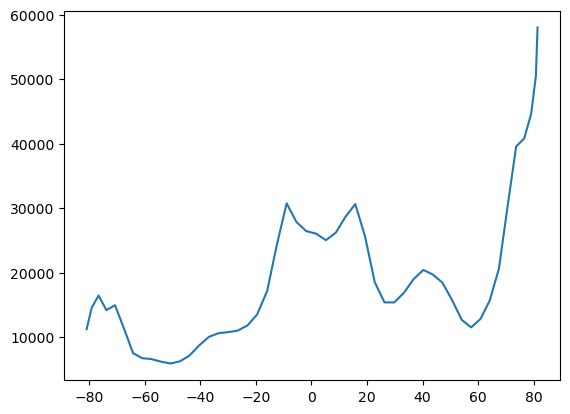

In [209]:
plt.plot(single_pass_df.glat, single_pass_df.edens)

In [211]:
## Luckily these look pretty similar!! Now we need to get these two plots to match as well as possible:


# You will need to work on the background removal. I can help!

# Phil is working on something VERY similar. I think you guys should both get something & compare...


# Options:
# - bandpass filter (lims @ 150 & 300 sec - need to convert that to glat)
# - Rolling average (modules available in pandas and xarray - look at documentation)
# - quiet time averages?? (I dont think this will work very well though...)
# - polynomial fits along longitudes (x,y) = (lat, edens).... adjust order to get good results.



# When you find something that works, we need to make sure it works for multiple passes &  multiple storms!!

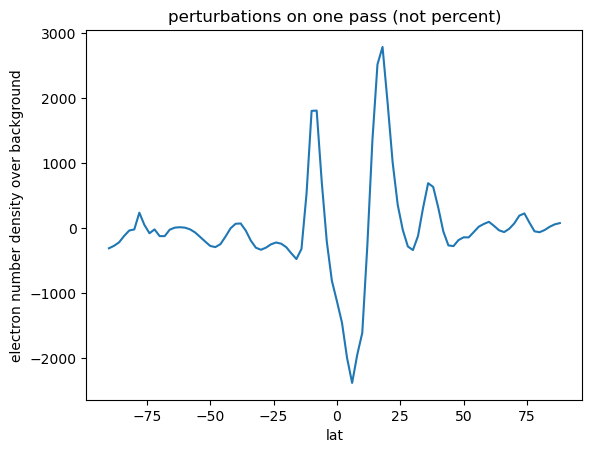

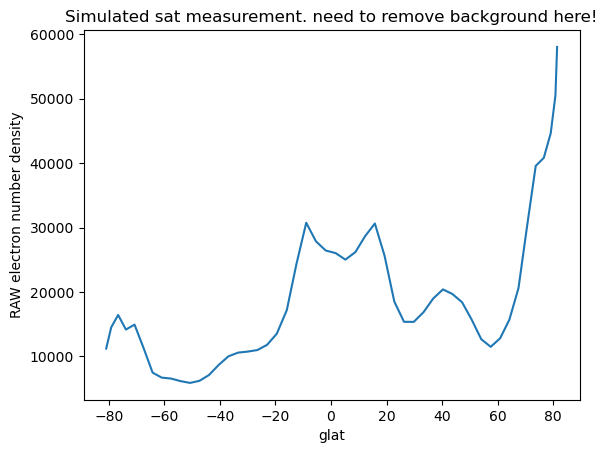

In [216]:
# so here's what we need to match. Doesn't have to be perfect though. Just kinda close...

filt_filt(samids.edens.sel(lon=glon_here, method='nearest', alt=850), percent=False).sel(
    time=single_pass_df.time.mean(), method='nearest').plot()
plt.title('perturbations on one pass (not percent)')
plt.ylabel('electron number density over background')
plt.show()


plt.plot(single_pass_df.glat, single_pass_df.edens)
plt.ylabel('RAW electron number density')
plt.xlabel('glat')
plt.title('Simulated sat measurement. need to remove background here!')
plt.show()

/tmp/ipykernel_19958/2581549961.py:4: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['time'], dtype='object')
  rolling_bg = single_pass_df.rolling(on='glat', window=6, center=True).mean()


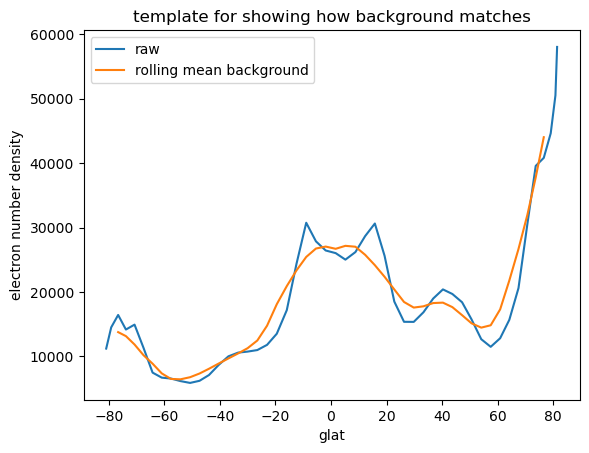

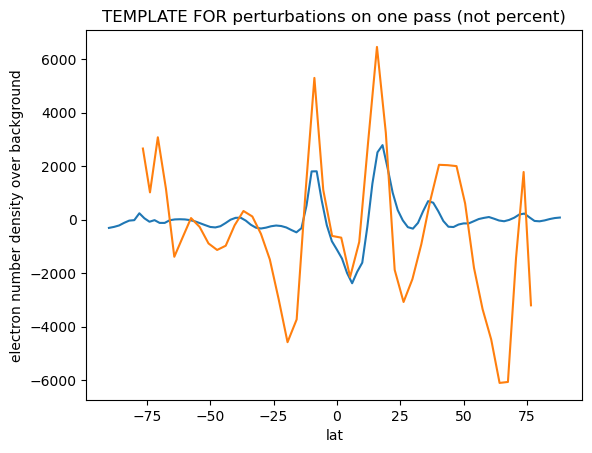

In [230]:
# Here's how you can present it. 
# THis is super basic so you will need to change almost all of it. Just use this for reference.

rolling_bg = single_pass_df.rolling(on='glat', window=6, center=True).mean()

plt.plot(single_pass_df.glat, single_pass_df.edens, label='raw')
plt.plot(rolling_bg.glat, rolling_bg.edens, label='rolling mean background')
plt.legend()

plt.ylabel('electron number density')
plt.xlabel('glat')
plt.title('template for showing how background matches')
plt.show()


filt_filt(samids.edens.sel(lon=glon_here, method='nearest', alt=850), percent=False).sel(
    time=single_pass_df.time.mean(), method='nearest').plot(label='real perturbations')
plt.plot(single_pass_df.glat, single_pass_df.edens-rolling_bg.edens, label='rolling perturbs')

plt.title('TEMPLATE FOR perturbations on one pass (not percent)')
plt.ylabel('electron number density over background')
plt.show()

In [231]:
"""

SO you can see this is fairly close, which is awesome, especially for a first pass.


Now it's time to look at more passes and more background removal techniques.

It may be easier (and definitely neater) to wrap things you use a lot in functions, like I did for the filter thing. It saves you from having to rewrite all of that stuff, every time.


""";